# Consommation de viandes et oeufs au Canada

La consommation de viandes en baisse au Canada? Voyons les chiffre.

D'abord, charger les modules de calcul.

In [1]:
import pandas as pd
import numpy as np
import altair as alt

Puis, charger les données. Les chiffres de Statistique Canada, [transformés par Agriculture et Agroalimentaire Canada](http://www.agr.gc.ca/fra/industrie-marches-et-commerce/renseignements-sur-les-secteurs-canadiens-de-lagroalimentaire/viande-rouge-et-betail/information-sur-le-marche-des-viandes-rouges/consommation-de-viande-et-proteine-animale/?id=1415860000022), peuvent être copiés dans un tableau, puis enregistrés en format csv. Les données sont exprimeés en kg de poids désossé. Ces chiffres sont exprimés en kg par personne. Pour obtenir la consommation totale, on a besoin de la population totale. La [Banque mondiale offre de telles données](https://data.worldbank.org/indicator/SP.POP.TOTL?locations=CA).

In [2]:
data = pd.read_csv('viande.csv')
pop = pd.read_csv('popcan.csv')
data = pd.merge(data, pop, how='left', on='Année')
data['Année'] = pd.to_datetime(data['Année'], format='%Y')
data.head()

Année  Poulet  Poule  Dindon  Boeuf   Porc  Veau  Agneau et mouton  \
0 1980-01-01   11.39   0.84    3.30  27.09  22.87  0.95              0.52   
1 1981-01-01   11.19   0.88    3.22  27.82  22.28  1.04              0.45   
2 1982-01-01   11.14   0.91    3.07  27.58  20.44  1.09              0.47   
3 1983-01-01   10.95   1.02    3.15  27.42  21.13  1.07              0.51   
4 1984-01-01   11.56   0.89    3.07  26.15  20.55  1.16              0.55   

   Poisson  Oeufs douzaine       Pop  
0      NaN           21.96  24277000  
1      NaN           21.64  24593000  
2      NaN           21.58  24900000  
3      NaN           21.05  25202000  
4      NaN           20.19  25456000

Pour obtenir la masse d'oeuf en kg, je prends 50g par oeuf.

In [3]:
data['Oeufs'] = data['Oeufs douzaine']/12 * 0.05
data.drop('Oeufs douzaine', axis=1, inplace=True)

J'identifie ensuite les colonnes des tableaux concernant les aliments, j'en fais le total par personne, puis je multiplie par la population pour avoir le total canadien.

In [4]:
aminaux_col = ['Poulet', 'Poule', 'Dindon', 'Boeuf', 'Porc', 'Veau', 'Agneau et mouton', 'Poisson', 'Oeufs']
data['produits animaux'] = data[aminaux_col].sum(axis=1)
aminaux_col.append('produits animaux')

In [5]:
data_tot = data.copy()
data_tot[aminaux_col] = data_tot[aminaux_col].mul(data["Pop"], axis=0)

Je transforme les tableaux en format long (utile pour créer des graphqiues).

In [6]:
data = data.melt(id_vars = ['Année', 'Pop'])
data_tot = data_tot.melt(id_vars = ['Année', 'Pop'])

Il est intéressant de présenter ces données sous forme de nombre d'animaux abattus. Il me faut donc le poids de viande obtenu par animal, ce qui est une grossière estimation: je me contenterai de l'estimer seulement pour les trois animaux majeurs: le boeuf, le porc et le poulet.

In [7]:
animaux = pd.DataFrame({'variable': ['Poulet', 'Porc', 'Boeuf'],
              'Poids': [1.6, 45, 370]})
animaux

variable  Poids
0   Poulet    1.6
1     Porc   45.0
2    Boeuf  370.0

Je fusionne le tableau des poids à mes deux tableaux en format long.

In [8]:
data = pd.merge(data, animaux, how = "left", on='variable')
data['animal'] = data.value / data["Poids"].values

In [9]:
data_tot = pd.merge(data_tot, animaux, how = "left",on='variable')
data_tot['animal'] = data_tot.value / data_tot["Poids"].values

Je n'en fais qu'un seul tableau, tenant compte de leur type.

In [10]:
data["Type"] = "Per capita"
data_tot["Type"] = "Total"
data_concat = pd.concat([data, data_tot], axis=0, ignore_index=True)

Je calcule le nombre total d'animaux abattus, puis l'insère dans le tableau.

In [11]:
animal_annee = data[['Année', 'variable', 'animal']].groupby(['Année']).sum().reset_index()
animal_annee_tot = data_tot[['Année', 'variable', 'animal']].groupby(['Année']).sum().reset_index()
animal_annee['Type'] = "Per capita"
animal_annee['variable'] = "produits animaux"
animal_annee_tot['Type'] = "Total"
animal_annee_tot['variable'] = "produits animaux"

In [12]:
data_concat.loc[(data_concat.variable == "produits animaux") & (data_concat.Type == "Per capita"), "animal"] = animal_annee.animal.values
data_concat.loc[(data_concat.variable == "produits animaux") & (data_concat.Type == "Total"), "animal"] = animal_annee_tot.animal.values

In [13]:
data_concat.sample(10)

Année       Pop          variable         value  Poids     animal  \
348 1986-01-01  25942000  produits animaux  6.504158e+01    NaN   8.483299   
372 2010-01-01  33628571  produits animaux  6.646808e+01    NaN  11.868428   
225 2015-01-01  35535348              Veau  6.800000e-01    NaN        NaN   
597 2007-01-01  32570505              Veau  2.801063e+07    NaN        NaN   
437 1999-01-01  30247900             Poule  3.387765e+07    NaN        NaN   
266 1980-01-01  24277000           Poisson           NaN    NaN        NaN   
590 2000-01-01  30499200              Veau  2.744928e+07    NaN        NaN   
122 1988-01-01  26550000             Boeuf  2.421000e+01  370.0   0.065432   
25  2005-01-01  31995000            Poulet  1.850000e+01    1.6  11.562500   
242 1994-01-01  28833410  Agneau et mouton  5.400000e-01    NaN        NaN   

           Type  
348  Per capita  
372  Per capita  
225  Per capita  
597       Total  
437       Total  
266  Per capita  
590       Total  
122  Per capita  
25   Per capita  
242  Per capita

Voici ce que ça donne en terme de masse per capita et au total, par type de viande, incluant la somme des types de viandes.

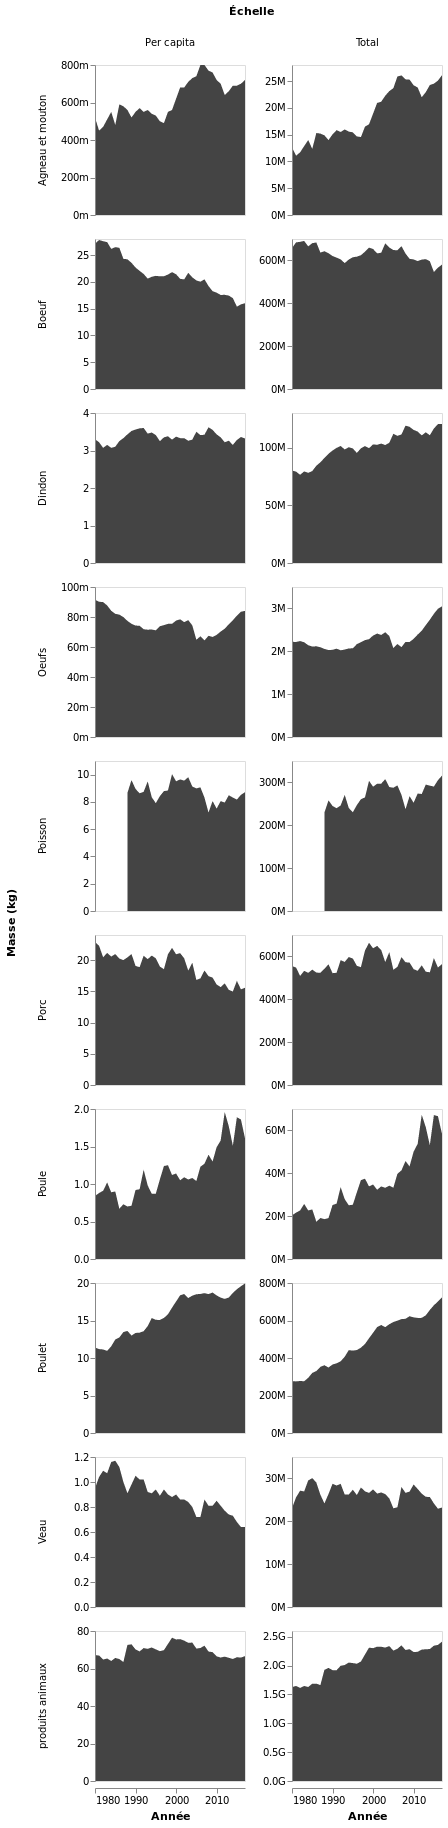

In [14]:
alt.Chart(data_concat).\
    mark_area(color = "#444444").\
    encode(x=alt.X('Année:T', axis=alt.Axis(format='%Y', title='Année', grid=False)),
           y=alt.Y('value:Q', axis=alt.Axis(format='s', title=None, grid=False))).\
    properties(width=150,
               height=150).\
    facet(row=alt.Row('variable:N', title='Masse (kg)'),
          column=alt.Column('Type:N', title='Échelle')).\
    resolve_scale(y='independent')

Puis par nombre d'animaux abattus, incluant seulement le boeuf, le porc et le poulet.

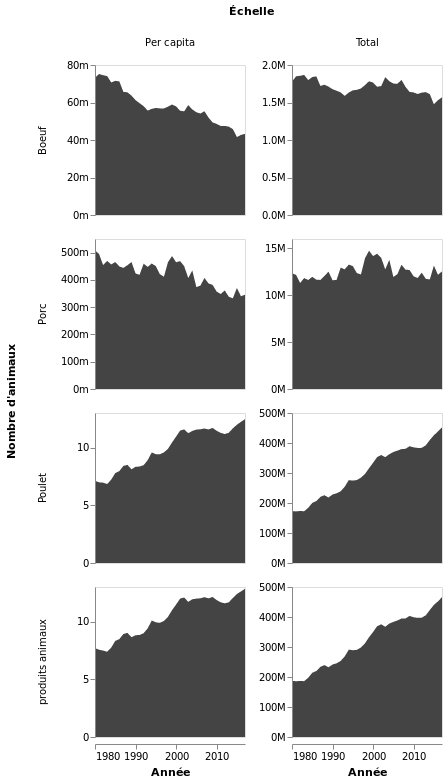

In [15]:
alt.Chart(data_concat[data_concat.variable.isin(["Poulet", "Boeuf", "Porc", "produits animaux"])]).\
    mark_area(color = "#444444").\
    encode(x=alt.X('Année:T', axis=alt.Axis(format='%Y', title='Année', grid=False)),
           y=alt.Y('animal:Q', axis=alt.Axis(format='s', title=None, grid=False))).\
    properties(width=150,
               height=150).\
    facet(row=alt.Row('variable:N', title="Nombre d'animaux"),
          column=alt.Column('Type:N', title='Échelle')).\
    resolve_scale(y='independent')

# Statistiques

In [16]:
import statsmodels.regression.linear_model as sm

In [17]:
data["Temps"] = (data['Année'] - data['Année'].min())  / np.timedelta64(1,'Y')
data_tot["Temps"] = (data_tot['Année'] - data_tot['Année'].min())  / np.timedelta64(1,'Y')

Je lance un modèle linéaire tiré du tableau per capita, puis un autre tiré du tableau total.

In [18]:
models = []
models_tot = []
for variable in aminaux_col:
    data_variable = data.loc[data.variable == variable, ['value', 'Temps']].dropna(axis=0)
    data_variable_tot = data_tot.loc[data_tot.variable == variable, ['value', 'Temps']].dropna(axis=0)
    models.append(sm.OLS.from_formula("value ~ Temps", data = data_variable).fit())
    models_tot.append(sm.OLS.from_formula("value ~ Temps", data = data_variable_tot).fit())

In [19]:
pval = []
slope = []
pval_tot = []
slope_tot = []

for i in range(len(models)):
    pval.append(models[i].f_pvalue)
    slope.append(models[i].params[1])
    pval_tot.append(models_tot[i].f_pvalue)
    slope_tot.append(models_tot[i].params[1])

Les pentes per capita:

In [20]:
pd.DataFrame({'Slope': slope,
             'is significant': np.array(pval) < 0.05},
            index = aminaux_col)

Slope  is significant
Poulet            0.246677            True
Poule             0.026543            True
Dindon            0.002214           False
Boeuf            -0.295730            True
Porc             -0.169514            True
Veau             -0.011323            True
Agneau et mouton  0.007368            True
Poisson          -0.030505            True
Oeufs            -0.000304            True
produits animaux  0.019804           False

Les pentes au total:

In [21]:
pd.DataFrame({'Slope': slope_tot,
             'is significant': np.array(pval_tot) < 0.05},
            index = aminaux_col)

Slope  is significant
Poulet            1.234474e+07            True
Poule             1.197107e+06            True
Dindon            1.114076e+06            True
Boeuf            -2.009357e+06            True
Porc              8.122698e+05           False
Veau             -5.800245e+04            True
Agneau et mouton  4.164615e+05            True
Poisson           1.789621e+06            True
Oeufs             1.652979e+04            True
produits animaux  2.186947e+07            True

Pour vérifier la pente des produits animaux per capita...

In [22]:
i=9
print(aminaux_col[i])
models[i].summary()

produits animaux


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.024
Method:                 Least Squares   F-statistic:                    0.1318
Date:                Tue, 06 Nov 2018   Prob (F-statistic):              0.719
Time:                        01:45:06   Log-Likelihood:                -102.48
No. Observations:                  38   AIC:                             209.0
Df Residuals:                      36   BIC:                             212.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     68.8802      1.173     58.713      0.000      66.501      71.260
Temps          0.0198      0.055      0.363      0.719      -0.091       0.130
==============================================================================
Omnibus:                        5.773   Durbin-Watson:                   0.337
Prob(Omnibus):                  0.056   Jarque-Bera (JB):                2.428
Skew:                           0.293   Prob(JB):                        0.297
Kurtosis:                       1.909   Cond. No.                         42.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

J'effectue la même procédure pour le nombre d'animauc abattus.

In [24]:
models = []
models_tot = []
for variable in ['Boeuf', 'Porc', 'Poulet']:
    data_variable = data.loc[data.variable == variable, ['animal', 'Temps']].dropna(axis=0)
    data_variable_tot = data_tot.loc[data_tot.variable == variable, ['animal', 'Temps']].dropna(axis=0)
    models.append(sm.OLS.from_formula("animal ~ Temps", data = data_variable).fit())
    models_tot.append(sm.OLS.from_formula("animal ~ Temps", data = data_variable_tot).fit())

In [25]:
pval = []
slope = []
pval_tot = []
slope_tot = []
for i in range(len(models)):
    pval.append(models[i].f_pvalue)
    slope.append(models[i].params[1])
    pval_tot.append(models_tot[i].f_pvalue)
    slope_tot.append(models_tot[i].params[1])

In [26]:
pd.DataFrame({'Slope': slope,
             'is significant': np.array(pval) < 0.05},
             index = ['Boeuf', 'Porc', 'Poulet'])

Slope  is significant
Boeuf  -0.000799            True
Porc   -0.003767            True
Poulet  0.154173            True

In [27]:
pd.DataFrame({'Slope': slope_tot,
             'is significant': np.array(pval_tot) < 0.05},
            index = ['Boeuf', 'Porc', 'Poulet'])

Slope  is significant
Boeuf  -5.430694e+03            True
Porc    1.805044e+04           False
Poulet  7.715462e+06            True